<a href="https://colab.research.google.com/github/tontantip/DADS7102_Applied_Optimization-Predictive_Analytics/blob/main/optimization_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

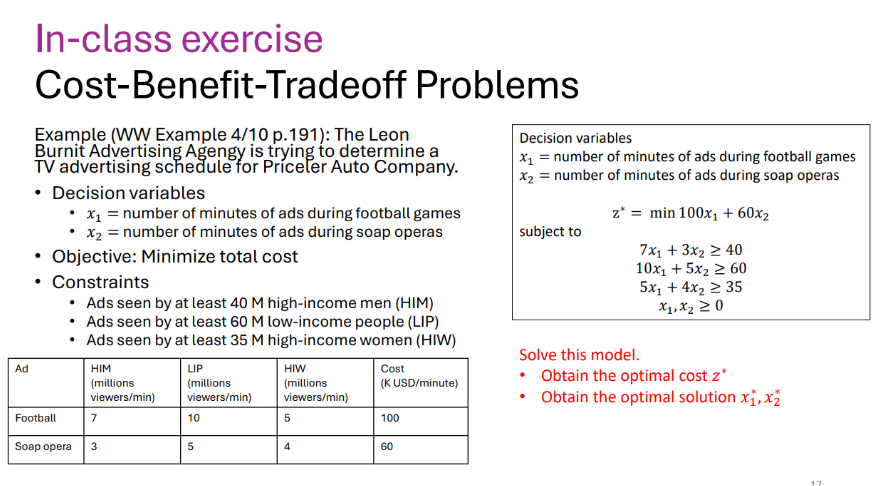

In [ ]:
# linprog
import numpy as np
from scipy.optimize import linprog

# LP: product mix example
objCoef = np.array([100.0, 60.0]) ## maximize *-1, minimize ไม่ *-1
AMx = np.array([[-7, -3],
               [-10, -5],
                [-5,-4]])
RHS = np.array([-40, -60,-35])
#x0_bounds = (0, 600)
#x1_bounds = (0, 1200)
opt = linprog(c = objCoef, A_ub = AMx, b_ub = RHS)
opt

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 633.3333333333333
              x: [ 4.333e+00  3.333e+00]
            nit: 2
          lower:  residual: [ 4.333e+00  3.333e+00]
                 marginals: [ 0.000e+00  0.000e+00]
          upper:  residual: [       inf        inf]
                 marginals: [ 0.000e+00  0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 3.333e-01  0.000e+00  0.000e+00]
                 marginals: [-0.000e+00 -6.667e+00 -6.667e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [ ]:
# AMPL Python API
%pip install -q amplpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 48.9 MB/s eta 0:00:00


In [ ]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["coin", "highs", "gokestrel", "gurobi"],  # modules to install
    license_uuid="your-license-uuid",  # license to use
)  # instantiate AMPL object and register magics

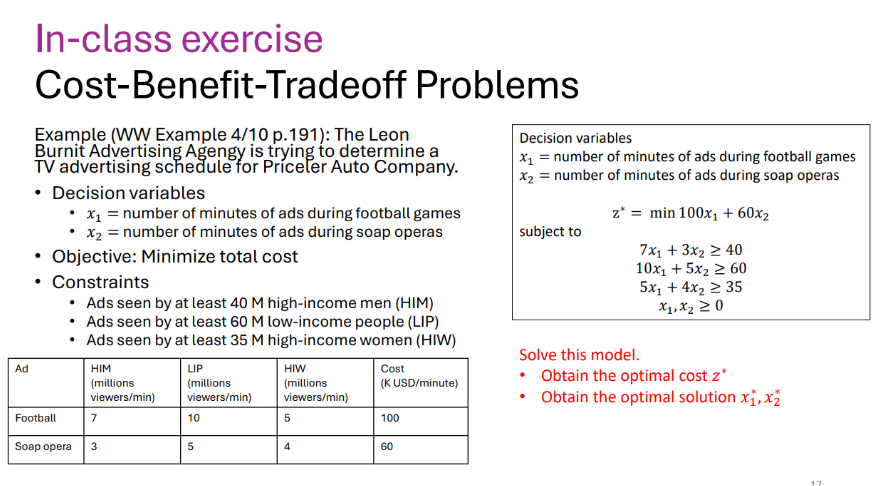

In [ ]:
# LP: product mix example

%%ampl_eval

reset;

var x1 >= 0;
var x2 >= 0;

minimize objective: 100*x1 + 60*x2;

s.t. assemblyCon: 7*x1 + 3*x2 >= 40;
s.t. testCon: 10*x1 + 5*x2 >= 60;
s.t. testets: 5*x1 + 4*x2 >= 35;

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()
ampl.get_data("x1", "x2").to_pandas()

Gurobi 13.0.0: Gurobi 13.0.0: optimal solution; objective 633.3333333
3 simplex iterations


,x1,x2
0,4.333333,3.333333


In [ ]:
# NLP: Chance constraint

%%ampl_eval

reset;
var x1 >= 0, <= 600;
var x2 >= 0, <= 1200;
var y >= 0;

maximize objective: 80*x1 + 129*x2;

s.t. assemblyCon: 5*x1 + 6*x2 + 1.282*y <= 10000;
s.t. testCon: x1 + 2*x2 <= 3000;
s.t. yDef: y^2 >= (1.6^2)*x1^2 + (2.3^2)*x2^2;

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()
ampl.get_data("x1", "x2", "y").to_pandas()

Gurobi 13.0.0: Gurobi 13.0.0: optimal solution; objective 145576.5857
0 simplex iterations
9 barrier iterations


,x1,x2,y
0,330.425805,923.585437,2189.04708


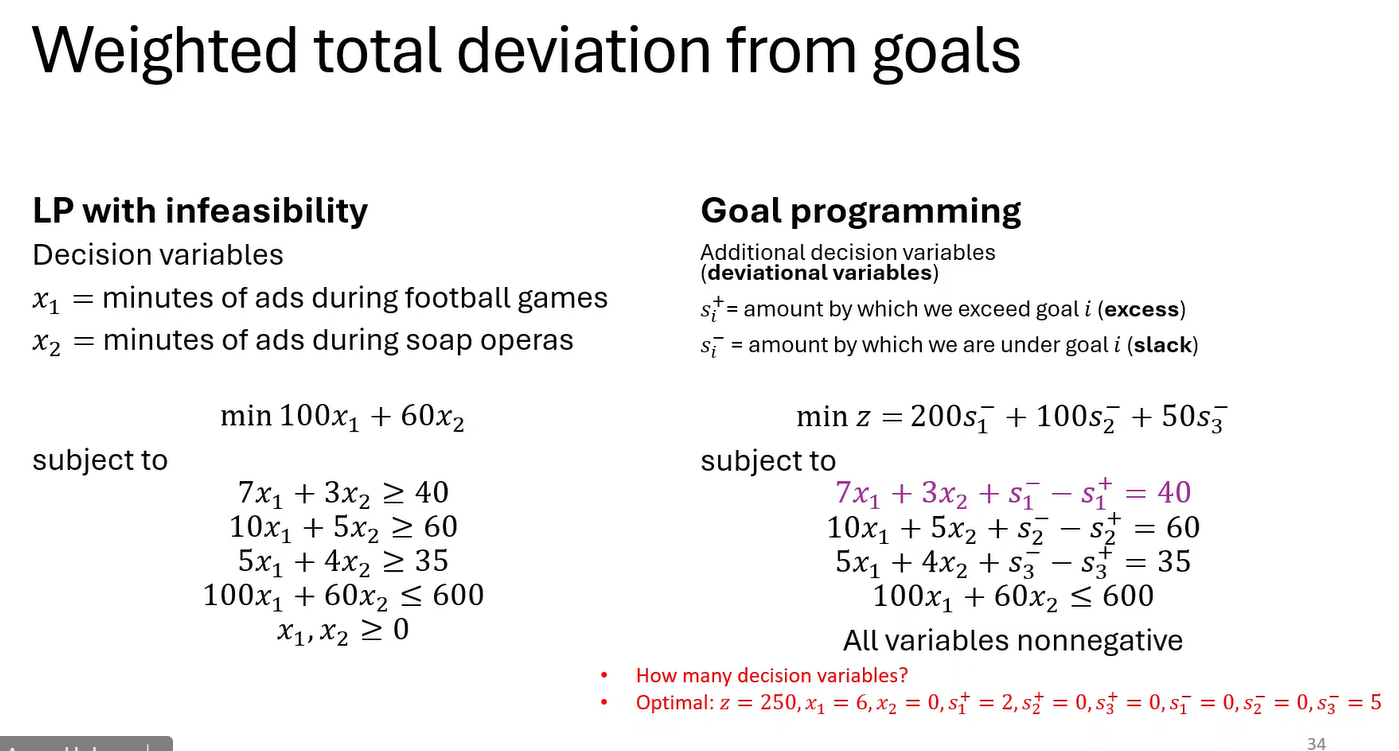

In [ ]:
# LP: product mix example

%%ampl_eval

reset;

var x1 >= 0;
var x2 >= 0;
var s1p >= 0;
var s1m >= 0;
var s2p >= 0;
var s2m >= 0;
var s3p >= 0;
var s3m >= 0;

minimize objective: 200*s1m + 100*s2m + 50*s3m;

s.t. assemblyCon: 7*x1 + 3*x2 + s1m - s1p == 40;
s.t. testCon: 10*x1 + 5*x2 + s2m - s2p == 60;
s.t. testets: 5*x1 + 4*x2 + s3m - s3p == 35;
s.t. testets1: 100*x1 + 60*x2  <= 600;


In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()
ampl.get_data("x1", "x2", "s1p", "s1m","s2p","s2m","s3p","s3m").to_pandas()

Gurobi 13.0.0: Gurobi 13.0.0: optimal solution; objective 250
0 simplex iterations


,x1,x2,s1p,s1m,s2p,s2m,s3p,s3m
0,6,0,2.0,0,0,0,0,5


In [ ]:
%%ampl_eval
reset;

param nProd;
param nLine;

set PROD := 1..nProd;
set LINE := 1..nLine;

param laborAsb{PROD};
param laborTest{PROD, LINE};
param margin{PROD, LINE};
param demand{PROD};
param capAsb;
param capTest{LINE};

var x{PROD, LINE} >= 0;
var xTotal{i in PROD} >= 0;

maximize profit: sum{i in PROD}(sum{j in LINE} margin[i,j]*x[i,j]);
s.t. conDemand{i in PROD}:  xTotal[i] <= demand[i];
s.t. conCapAsb: sum{i in PROD} laborAsb[i]*xTotal[i] <= capAsb;
s.t. conCapTest{j in LINE}: sum{i in PROD} laborTest[i,j]*x[i,j] <= capTest[j];
s.t. xTotalDef{i in PROD}:  xTotal[i] == sum{j in LINE} x[i,j];

data;

param nProd := 8;
param nLine := 2;

param margin (tr):  1	2	3  4 5 6  7 8 :=
1 127.50	132.00	142.00	152.00	142.00	167.00	172.00	177.00
2 122.00	127.50	137.50	147.50	138.50	163.50	160.00	174.50;

param laborTest (tr): 1 2 3 4 5 6 7 8 :=
1  1.5	2	2	2	2.5	2.5	2.5	3
2  2	2.5	2.5	2.5	3	3	3.5	3.5;

param capTest := 1 5000 2 6000;
param capAsb := 20000;

param: laborAsb demand :=
1	4	1500
2	5	1250
3	5	1250
4	5	1250
5	5.5	1000
6	5.5	1000
7	5.5	1000
8	6	800;

In [ ]:
ampl.option["solver"] = "gurobi"
ampl.solve()

Gurobi 13.0.0: Gurobi 13.0.0: optimal solution; objective 615812.5
11 simplex iterations
